## Song Recommender Prototype
The dataset contains
- 1,019,318 unique users
- 384,546 unique MSD songs
- 48,373,586 user-song-playcount triplets

Issues: Too much data. 1) Noise introduced by low-playcount records 2) Taking too long to train models

## 1. Setup

In [ ]:
!pip install --quiet cornac==1.6.1

     |████████████████████████████████| 10.1MB 2.5MB/s 


In [ ]:
!git clone https://github.com/srendle/libfm.git
!make all -C libfm

Cloning into 'libfm'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 129.46 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (112/112), done.
make: Entering directory '/content/libfm'
cd src/libfm; make all
make[1]: Entering directory '/content/libfm/src/libfm'
g++ -O3 -Wall -c libfm.cpp -o libfm.o
mkdir -p ../../bin/
g++ -O3 -Wall libfm.o -o ../../bin/libFM
g++ -O3 -Wall -c tools/transpose.cpp -o tools/transpose.o
mkdir -p ../../bin/
g++ -O3 tools/transpose.o -o ../../bin/transpose
g++ -O3 -Wall -c tools/convert.cpp -o tools/convert.o
mkdir -p ../../bin/
g++ -O3 tools/convert.o -o ../../bin/convert
make[1]: Leaving directory '/content/libfm/src/libfm'
make: Leaving directory '/content/libfm'


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

import cornac
from cornac.data import Reader
from cornac.eval_methods import BaseMethod, RatioSplit
from cornac.models import Recommender, BPR, WMF

%load_ext autoreload
%autoreload 2
%matplotlib inline
%tensorflow_version 1.x
import tensorflow as tf

print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

# data processing
MIN_PLAYCOUNT = 5
MAX_PLAYCOUNT = 150
MIN_SONG_PER_USER = 20
MIN_USER_PER_SONG = 50

TEST_RATIO = 0.33
SEED = 2020
VERBOSE = False
PLAY_COUNT_DATA_PATH = "gdrive/My Drive/Data/train_triplets.txt"
TRAIN_DATA_PATH = "gdrive/My Drive/Data/triplets_train.csv"
TEST_DATA_PATH = "gdrive/My Drive/Data/triplets_test.csv"
FILTERED_DATA_PATH = "gdrive/My Drive/Data/filtered_triplets.csv"
TRACK_METADATA_PATH = "gdrive/My Drive/Data/track_metadata.db"
MODEL_DIR="gdrive/My Drive/Models/"

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. Data Exploration

In [ ]:
data = pd.read_csv(PLAY_COUNT_DATA_PATH, sep="\t", names=["user_id", "song_id", "play_count"], header=None) 

In [ ]:
data.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


#### Data Sparsity

In [ ]:
def display_sparsity(data):
    n_users = data.user_id.nunique()
    n_songs = data.song_id.nunique()
    n_playcounts = len(data)
    playcount_matrix_size = n_users * n_songs
    sparsity = 1 - n_playcounts / playcount_matrix_size

    print(f"Number of unique users: {n_users}")
    print(f"Number of unique songs: {n_songs}")
    print(f"Number of available playcounts: {n_playcounts}")
    print(f"Number of all possible playcounts: {playcount_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.5f}%")

In [ ]:
display_sparsity(data)

Number of unique users: 1019318
Number of unique songs: 384546
Number of available playcounts: 48373586
Number of all possible playcounts: 391974659628
----------------------------------------
SPARSITY: 99.98766%


#### Top 10 songs by number of users who have played it

In [ ]:
song_play_num_users = data.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users.head(10)

song_id
SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
SONYKOW12AB01849C9     78353
SOEGIYH12A6D4FC0E3     69487
SOLFXKT12AB017E3E0     64229
SODJWHY12A8C142CCE     63809
SOFLJQZ12A6D4FADA6     58610
Name: user_id, dtype: int64

#### Bottom 10 songs by number of users who have played it

In [ ]:
song_play_num_users.tail(10)

song_id
SONJAWX12A8C13E25B    1
SOKRIGC12A8C1372F1    1
SOPKNIR12A8C138662    1
SORKHCW12A8C13D894    1
SOKRHUB12AB017E7FA    1
SOHEVJV12AC468C3FF    1
SOZCCGY12A8C12FF83    1
SOEPLCT12AB018AF1D    1
SOHEVIS12AB0186DF6    1
SORLFZJ12A8C13341C    1
Name: user_id, dtype: int64

#### Top 10 users with most number of songs

In [ ]:
user_num_songs = data.groupby("user_id")["song_id"].nunique().sort_values(ascending=False)
user_num_songs.head(10)

user_id
ec6dfcf19485cb011e0b22637075037aae34cf26    4400
8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc    1651
fef771ab021c200187a419f5e55311390f850a50    1614
5a3417a1955d9136413e0d293cd36497f5e00238    1604
c1255748c06ee3f6440c51c439446886c7807095    1566
4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f    1544
cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6    1536
96f7b4f800cafef33eae71a6bc44f7139f63cd7a    1491
119b7c88d58d0c6eb051365c103da5caf817bea6    1451
b7c24f770be6b802805ac0e2106624a517643c17    1446
Name: song_id, dtype: int64

#### Bottom 10 users with least number of songs
A user has at least listened to 10 songs.

In [ ]:
user_num_songs.tail(10)

user_id
2fd4c99cdc1232e9012299c6e41cb4a9f109a6a9    10
6b6ad4921f7510f48199c44c3f25e9045942373f    10
c531dc896216b11865071bd5f07d408e678c24da    10
c531c61652640db5e3d51c670c1df9cdb659698d    10
c52fedd2d9b96ccf22d3ff8775a82ccb62ad4fbe    10
c52fd9d20260585850f260fed445b633df9b3b71    10
1d477e518edfb3ebc6e56951e55570af25daffe3    10
6b6e2a832c28b6e09ac1b02f277c6cd821418020    10
2fd3dba782fe0b3ba2248e3b1153cdae97dcebc5    10
a546a96e6e0f12423bc27c01b2f43446ff0ca012    10
Name: song_id, dtype: int64

#### Data Statistics

In [ ]:
data.describe()

,play_count
count,48373586.000
mean,2.867
std,6.438
min,1.000
25%,1.000
50%,1.000
75%,3.000
max,9667.000


#### Power Law Distribution

In [ ]:
sample_size = 5000
seed = 2020
sample_df = song_play_num_users.sample(n=sample_size, random_state=seed)
sample_df = sample_df.sort_values(ascending=False)

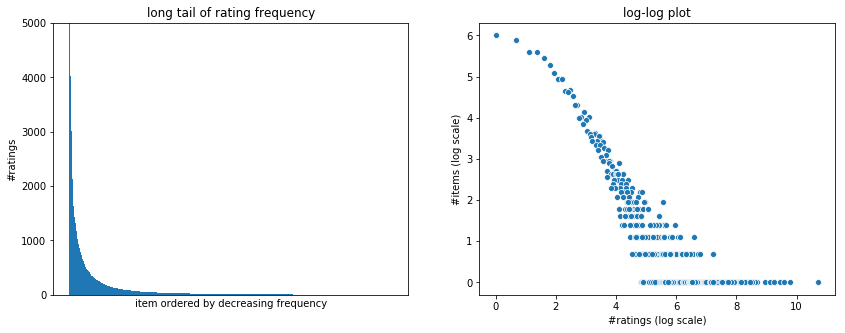

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=sample_df.index, height=sample_df.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")
axes[0].set_ylim([0, 5000])

count = sample_df.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

#### Get Song Metadata

In [ ]:
conn = sqlite3.connect(TRACK_METADATA_PATH)
conn.commit()
c = conn.cursor()
c.execute('SELECT * FROM songs')
metadata = DataFrame(
    c.fetchall(), 
    columns=['track_id','title','song_id','release','artist_id','artist_mbid','artist_name',
             'duration','artist_familiarity','artist_hottness','year','track_7digitalid','shs_perf','shs_work']
)

In [ ]:
metadata.head(5)

## 3. Data Processing

#### Filter ratings by play count
Users might accidentally play a song. By removing ratings with less than 5 play counts, we try to remove this noise.

In [ ]:
filtered_df = data[(data['play_count'] >= MIN_PLAYCOUNT) & (data['play_count'] <= MAX_PLAYCOUNT)]

#### Filter songs with number of users
It's hard to infer the general likeability of a song if there are too few ratings.

In [ ]:
filtered_df = filtered_df.groupby(['song_id']).filter(lambda x: x['user_id'].nunique() >= MIN_USER_PER_SONG)

In [ ]:
display_sparsity(filtered_df)

Number of unique users: 730954
Number of unique songs: 23940
Number of available playcounts: 5543028
Number of all possible playcounts: 17499038760
----------------------------------------
SPARSITY: 99.96832%


In [ ]:
song_play_num_users = filtered_df.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users.tail(10)

song_id
SOZUEBF12AB0180EEA    50
SOVXQCK12A8AE453E9    50
SORZYWW12AF729EB4C    50
SOGHSUA12AB017F309    50
SOMAYVG12A58A7CC6D    50
SOGIWOH12A6D4F9646    50
SOSBKOE12A6D4F7D09    50
SOLZGBY12A6D4F8127    50
SOLZCPW12A8C1384AF    50
SOBORCP12A8C13FEF2    50
Name: user_id, dtype: int64

In [ ]:
filtered_df.reset_index(drop=True)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOIZAZL12A6701C53B,5
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOKRIMP12A6D4F5DA3,5
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOMGIYR12AB0187973,6
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOMZWUW12A8C1400BC,6
...,...,...,...
5543023,cf8289419383259189afe6bb50c5115fd84f1064,SONJQAH12A8C13C2FF,7
5543024,cf8289419383259189afe6bb50c5115fd84f1064,SOUVDUK12A8AE489A3,6
5543025,cf8289419383259189afe6bb50c5115fd84f1064,SOWJIBM12A81C2242B,6
5543026,cf8289419383259189afe6bb50c5115fd84f1064,SOZCDWG12A6D4F81E1,6


#### Filter users with number of songs
We will not consider the cold-start problem at this stage, therefore we remove users with insufficent number of ratings.

In [ ]:
filtered_df = filtered_df.groupby(['user_id']).filter(lambda x: x["song_id"].nunique() >= MIN_SONG_PER_USER)

In [ ]:
display_sparsity(filtered_df)

Number of unique users: 57667
Number of unique songs: 23940
Number of available playcounts: 1810984
Number of all possible playcounts: 1380547980
----------------------------------------
SPARSITY: 99.86882%


In [ ]:
filtered_df.reset_index(drop=True)

,user_id,song_id,play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5
...,...,...,...
1810979,8305c896f42308824da7d4386f4b9ee584281412,SOUNZHU12A8AE47481,5
1810980,8305c896f42308824da7d4386f4b9ee584281412,SOVWADY12AB0189C63,5
1810981,8305c896f42308824da7d4386f4b9ee584281412,SOWCKVR12A8C142411,5
1810982,8305c896f42308824da7d4386f4b9ee584281412,SOWOMMY127F8096DF9,5


In [ ]:
user_num_songs = filtered_df.groupby("user_id")["song_id"].nunique().sort_values(ascending=False)
user_num_songs.tail(10)

user_id
305513a3ee86398cf856e9a273da625f042385b9    20
9e7ba73977f9947a8df3ead74e1d039309ab985a    20
83a05753542608b67700a6655a91aa10a0372568    20
5427cf539af2f955cc116cb31776a066892dfade    20
60db3514f82f757323081e741dac25a3bf5a1203    20
83a4ecdc33927dd1ad844065e4ce3c8da89b5df6    20
f754a32b3b7031aeea5dfcf8d6287852c56dea96    20
eb4398b5499fee90ae30100f53cfa0dc2326f8e2    20
83a66068d733cb7f316d55b73771ee85bbc8cfb2    20
865bada1695ca591385921f07488abc6e40c3f06    20
Name: song_id, dtype: int64

In [ ]:
song_play_num_users = filtered_df.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users.tail(10)

song_id
SOWRMPK12A6D4F94BE    3
SOECGJE12A8C1330BE    3
SOTKVMM12A8AE45C4A    3
SONFJEJ12A58A7DC9C    3
SOFCBVN12AB018EB9B    3
SOFAIQR12AB01874C3    3
SOCGTLS12AF72A579E    3
SOOCRSU12AB018CFED    2
SOMPMVQ12A58A78C8E    2
SOUNKTO12AB018593C    2
Name: user_id, dtype: int64

#### Save filtered data

In [ ]:
filtered_df.to_csv(FILTERED_DATA_PATH, sep='\t', header = None, index = False)

In [ ]:
filtered_df2 = pd.read_csv(FILTERED_DATA_PATH, sep="\t", names=["user_id", "song_id", "play_count"], header=None) 

#### Train-Test Split

In [ ]:
train, test = train_test_split(filtered_df, test_size=TEST_RATIO, shuffle=True, random_state=SEED)

In [ ]:
# test_df = pd.DataFrame()
# train_df = pd.DataFrame()

# N = users.shape[0]
# for i in tqdm(range(N)): # progress bar
#     user_subset = data[data['user_id'] == users[i]]
#     # get the total number of ratings for this user
#     num_of_rows = user_subset.shape[0]
#     # calculate cutoff point based on test ratio
#     cutoff = int(round(num_of_rows * TEST_RATIO))

#     test_df = test_df.append(user_subset[:cutoff])
#     train_df = train_df.append(user_subset[cutoff:])

In [ ]:
train_df = pd.DataFrame(train, columns=["user_id", "song_id", "play_count"])
test_df = pd.DataFrame(test, columns=["user_id", "song_id", "play_count"])

#### Data Statistics

In [ ]:
display_sparsity(train_df)

Number of unique users: 367774
Number of unique songs: 8356
Number of available playcounts: 1038113
Number of all possible playcounts: 3073119544
----------------------------------------
SPARSITY: 99.96622%


In [ ]:
display_sparsity(test_df)

Number of unique users: 259968
Number of unique songs: 8356
Number of available playcounts: 511310
Number of all possible playcounts: 2172292608
----------------------------------------
SPARSITY: 99.97646%


#### Save to CSV files

In [ ]:
train_df.to_csv(TRAIN_DATA_PATH, sep='\t', index = False)
test_df.to_csv(TEST_DATA_PATH, sep='\t', index = False)

## 4. Base Model

#### Read CSV files

In [ ]:
reader = Reader()
train_data = reader.read(TRAIN_DATA_PATH, sep="\t", skip_lines=1)
test_data = reader.read(TEST_DATA_PATH, sep="\t", skip_lines=1)

#### Define Evaluation Metrics and Method

In [ ]:
eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

In [ ]:
base_method = BaseMethod.from_splits(train_data, test_data, exclude_unknowns=True, seed=SEED, verbose=True)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 367774
Number of items = 8356
Number of ratings = 1038113
Max rating = 9667.0
Min rating = 10.0
Global mean = 20.4
---
Test data:
Number of users = 198864
Number of items = 8356
Number of ratings = 435142
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 367774
Total items = 8356


#### Train Base Models

In [ ]:
K = 50
bpr = BPR(k=K, max_iter=100, learning_rate=0.01, lambda_reg=0.001, 
          verbose=True, seed=SEED, name=f"song_BPR(K={K})")

In [ ]:
cornac.Experiment(eval_method=base_method, models=[bpr], metrics=eval_metrics, save_dir=MODEL_DIR).run()

#### Load Pre-trained Model

In [ ]:
PRETRAINED_MODEL_PATH = "gdrive/My Drive/Models/song_BPR(K=20).pkl"
bpr = Recommender.load(PRETRAINED_MODEL_PATH)

In [ ]:
results = base_method.evaluate(bpr, eval_metrics, True)
for each in results:
  print(each)


[song_BPR(K=20)] Training started!

[song_BPR(K=20)] Evaluation started!


(<cornac.experiment.result.Result at 0x7f277bc56ef0>, None)

#### BPR Latent Factors

In [ ]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(bpr.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

## 5. Hyperparameter Tuning